### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2016 ###

# Travel Planning #

#### Shengchao Liu (CS login: shengchao, email: shengchao@cs.wisc.edu)
#### Honghui Zhang (CS login: honghui, email: hzhang459@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
  1. [Basic Model](#2.A.-Basic-Model)
  2. [Visiting Bounded Model](#2.B.-Bounded-Model)
  3. [Adaptive Method](#2.C.-Adaptive-Method)
1. [Solution](#3.-Solution)
  1. [Initial Block](#3.A.-Initial_Block)
  2. [Bounded Model](#3.B.-Bounded-Model)
1. [Results and Discussion](#4.-Results-and-discussion)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

Suppose you have one or two available weeks, and you want to visit some cities in the U.S., especially for international students who just came to U.S., you may have a city list that you would like to visit, also another city list you don't want to pay a visit to. So how you can come up with a travel plan?

This question is very similar to TSP([Travelling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)). The Travelling Salesman problem is like this, suppose we have a bunch of cities and we would like visit all of them in a round trip. Target is to get the minimal length or cost of this round trip.

Another similar question we can apply here is the [Steiner Tree Problem](https://en.wikipedia.org/wiki/Steiner_tree_problem).  Steiner Tree problem can give a spanning tree, which forms a tree out of a complex graph, but under the condition that minimizing the spanning tree cost only cover the must-pass nodes. So if we apply that model into our problem, it's like get a special Steiner 'tree' that starts from the root and ends at root with just one path.

In our problem, given all the possible cities that we can choose to visit, and another must-visit city list. Then under time and expense constraints, we hope to find a route that maximizes the delight index. The delight index is based on the some travel index for each city plus delight index for each air flight. We may need to find a trade-off between these parameters. For example, in the graph below, we have twelve cities, and we need to choose which city to start and end with, then also specify all the must-visit cities and must-not-visit cities.


![alt text](http://pages.cs.wisc.edu/~shengchao/cs524/all_city_map.png)

To make our model more realistic, we fetch real data online. First we take [walk score](https://www.walkscore.com/cities-and-neighborhoods/) to measure each city, which makes sense considering most students like walking while travelling. About flight information, we utilize the [Expedia API](http://hackathon.expedia.com/directory), and calculate the delight index with a fixed function for each flight.

In part 2, we will first extract a basic model out of the problem, then apply more reasonable constraints. In part 3, we will give a specific code solution. Part 4 discuss the results, and part 5 just summarizes the whole problem.

## 2. Mathematical model ##


### 2.A. Basic Model ###

Assumption 1: we assume that flying from one city to another city takes exactly one day, and visiting one city takes exactly two days.

Assumption 2: Price didn't change within adjacent several days.

Assumption 3: Each city visit just once.

First notice we will introduce the incidence matrix $ matrix \in \cal{R}^{v \times e} $ in our model, where $v$ is the number of vertices or cities, and  $e$ is the number of edges, that is two times city number plus flight number(will explain why two time city number later), and $b$ is the supposed  The vector $edge \in \cal{R}^{e}$ is the edge choice. So apparently we can get these two contraints:

$$ matrix \times edge == b$$, where b is the supposed in- or out- degree for each vertice or city.

$$ abs(matrix) \times edge . \le 2$$, which means the sum of in- and out- degree for each city should be less than or equal to two.

Second we need to meet the time and cost limit. Suppose $city\_choice \in \cal{R}^{v}$ is binary value vector, and $city\_choice[i] = 1$ represents $city[i]$ will be visited, otherwise if $city\_choice[i] = 0$ will not visit $city[i]$. Same idea for $flight\_choice$ which represents whether or not taking $flight[i]$. So according to problem, we can get these two limits:

$$ flight\_choice' \times flight\_price \le total\_money $$

$$ 2sum( city_choice) +  sum(flight\_choice) \le total\_day $$

We still have one question not solved, that is why we need $2 \times city\_number$. Please consider the graph below, we split each city node into two. The reason we do that is that, suppose $edge$ is composed only by the $flight$, and we meet the constraints. But still, we don't know which city will form a single circle, like the $city_A$ in this graph, which means in the adaptive method, we will detect only one circle( that is $city_B$ - $city_C$ - $city_D$) in the graph, which is absolutely wrong. That's why we want to split each city node into two, because it can help us find all possible circles or subtours in the graph, then applying adaptive method will be reasonable.


<img src="http://pages.cs.wisc.edu/~shengchao/cs524/picture1.png" height="542" width="542">

To sum up, below is a standard form:

$$
\begin{aligned}
\underset{city\_choose,\, flight\_choose}{\text{maximize}}\qquad& city\_score' \times city\_choose + flight\_score' \times flight\_choose \\
\text{subject to:}\qquad& 
  matrix \times edge == b \\
& abs(matrix) \times edge . \le 2 \\
& flight\_choice' \times flight\_price \le total\_money \\
& 2sum( city_choice) +  sum(flight\_choice) \le total\_day \\
\end{aligned}
$$


### 2.B. Bounded Model ###

Then we may come up with another idea: in a more realistic scenario, people will have an upper bound travelling day for each city, instead of exactly 2 days, which makes sense because someone just hope to visit several different cities within 2 week-holiday.

Assumption: visiting day for each city will be bounded by a upper bound. And the delight index for visiting one city is calculated by the city score multiply by its corresponding visiting day.

We introduct a new vector $day\_each\_city \in \cal{R}^{v}$, denoting the travelling day for each city, and its upper bound is $city\_day\_upperlimit$. So apparently we can get following relations:

If $city\_choice[i] = 1$, then $day\_each\_city[i] \ge 1$.

If $city\_choice[i] = 0$, then $day\_each\_city[i] == 0$.

Then applying the if-then constraint:

$$ day\_each\_city[i] - 1 \ge m (1 - city\_choice[i]) = city\_choice[i] - 1$$

$$ day\_each\_city[i] \le M day\_each\_city[i] = city\_day\_upperlimit[i] \times day\_each\_city[i] $$

And also we notice that the upper bound for visiting each city $day\_each\_city \le city\_day\_upperlimit$ is included in the second if-then constraint, so we don't have to explicitly demonstrate it.

Therefore the standard form for this is below:


$$
\begin{aligned}
\underset{city\_choose,\, flight\_choose}{\text{maximize}}\qquad& city\_score' \times city\_choose + flight\_score' \times flight\_choose \\
\text{subject to:}\qquad& 
  matrix \times edge == b \\
& abs(matrix) \times edge . \le 2 \\
& flight\_choice' \times flight\_price \le total\_money \\
& 2sum( city_choice) +  sum(flight\_choice) \le total\_day \\
& day\_each\_city[i] - 1 \ge city\_choice[i] - 1 \\
& day\_each\_city[i] \le city\_day\_upperlimit[i] \times day\_each\_city[i]
\end{aligned}
$$

### 2.C. Adaptive Method ###

We apply the adaptive subtour elimination. Find subtours and the get the number of subtours. If the subtour number is bigger than one, then we add a constraint that this circle should not be reached, so that we can avoid having multiple circles in the graph.

One key tip is that, in our model, since we start our trip from Madison, the out-degree of Madison will be 1, and in-degree of Madison will be -1, in which case this will not form a circle itself. So we have to manually search the subtour starting from the Madison at first in each iteration, so that we can find the very first route starting from Madison and back to Madison.

<img src="http://pages.cs.wisc.edu/~shengchao/cs524/picture2.png" height="542" width="542">


## 3. Solution ##

### 3.A. Initial Block###

In the first two parts, we will present interactive block, initial and helpler functions.

In the interactive section, by default, we have these 12 cities:

<table>
    <tr>
        <th>City Name</th>
        <th>Number</th>
    </tr>
    
    <tr>
        <td>New York</td>
        <td>1</td>
    </tr>
    
    <tr>
        <td>Boston</td>
        <td>2</td>
    </tr>
    
    <tr>
        <td>Washington D.C.</td>
        <td>3</td>
    </tr>
    
    <tr>
        <td>Chicago</td>
        <td>4</td>
    </tr>
    
    <tr>
        <td>Minneapolis</td>
        <td>5</td>
    </tr>
    
    <tr>
        <td>Atlanta</td>
        <td>6</td>
    </tr>
    
    <tr>
        <td>Miami</td>
        <td>7</td>
    </tr>
    
    
    <tr>
        <td>Orlando</td>
        <td>8</td>
    </tr>
    
    
    <tr>
        <td>Los Angeles</td>
        <td>9</td>
    </tr>
    
    <tr>
        <td>San Francisco</td>
        <td>10</td>
    </tr>
    
    
    <tr>
        <td>Seattle</td>
        <td>11</td>
    </tr>
    
    <tr>
        <td>Madison</td>
        <td>12</td>
    </tr>
</table>

And in this interactive block, you are able to type in which city you want to visit and which city you don't want to visit. We define the vector $city\_requirement$ in this way:

$$ city\_requirement[i] = \begin{cases}
 1, & {\text{must visit city[i]}}\\
 0, & {\text{must not visit city[i]}}\\
-1, & {\text{possibly visit city[i]}}\\
\end{cases}
$$

And also you can declare which is the starting/ending city as the #seed\_city# here(which is also the ending city).

In [9]:
city_requirement = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1];
seed_city = 11;

### 3.B. Data Sorce###

We run our Python program ([expedia.py](https://github.com/lscHacker/Steiner-Tree-in-Flight-Scheduling/blob/master/expedia.py)), which uses Expedia API to capture real-time flight information and Google API to information. Also, in the Pyhton program, we use some functions to simulate the delight index.

$$ delight = 0.5 * \frac{1}{\#\ of\ segments} + 0.5 * \max(0, 1 - \frac{flight\ hours}{10.0})$$

Finally, we can generate the csv file ([flight.csv](https://github.com/lscHacker/Steiner-Tree-in-Flight-Scheduling/blob/master/flights.csv)), which records all the flight information that we need.

Then we form the $matrix$. As we discussed above, the first $2 city\_number$ whould describe the city itself, in case we don't want to visit somewhere else. For $city[i]$, we split it into two subnodes, $2i-1$ and $2i$. $2i-1$ is the in-degree node, and $2i$ is the out-degree node. Then add two edges: from $2i-1$ to $2i$ and from $2i$ back to $2i-1$. In this case, we will not miss the single-city circle.

And applying our splitting nodes concept for the flight from $city[u]$ to $city[v]$, we should add an edge from $2u$ to $2v-1$.

In our default setting, we are leaving from Madison, and back to Madison, which means the tour should start from $2 Madison_{index}$ and back to $2 Madison_{index} - 1$, so the b vector should have all zero except $b[2 Madison_{index}]=1$ and $b[2 Madison_{index}-1]=-1$.

In [2]:
locations = readdlm("locations.csv", ',')
city  = locations[2:end, 1]
lat   = locations[2:end, 3]
lon   = locations[2:end, 4]
score = locations[2:end, 5]
city_lat   = Dict(zip(city, lat))
city_lon   = Dict(zip(city, lon))
city_score = Dict(zip(city, score))
city_number = size(city, 1)
city_day_upperlimit = ones(city_number, 1) * 3
city_day_upperlimit[city_number] = 1

flights  = readdlm("flights.csv", ',')
departure_city    = flights[2:end, 1]
departure_airport = flights[2:end, 2]
arrival_city      = flights[2:end, 3]
arrival_airport   = flights[2:end, 4]
flight_date       = flights[2:end, 5]
flight_price      = flights[2:end, 6]
flight_comfort    = flights[2:end, 7]
flight_number     = size(flights, 1) - 1

# max amout of money spend on flight
max_money = 100000;
# max travel days
max_day = 10;

matrix = zeros(2city_number,2city_number + flight_number);
# split each city into two 'subcities'
for i = 1 : city_number
    matrix[2i-1, 2i-1] = 1
    matrix[2i  , 2i-1] = -1
    
    matrix[2i-1, 2i] = -1
    matrix[2i  , 2i] = 1
end
for i = 1 : flight_number
    u = 1
    v = 1
    for j = 1 : city_number
        if departure_city[i] == city[j]
            u = j
        end
        if arrival_city[i] == city[j]
            v = j
        end
    end
    matrix[2u  ,i+2city_number] = 1
    matrix[2v-1,i+2city_number] = -1
end

b = zero(1:2city_number);
b[2seed_city-1] = -1;
b[2seed_city] = 1;

These are the helper functions.

The function getAllSubtours() gets all the subtours given the edges that we choose in each iteration. It calls function getSubtour(), which starts from one edge and find a circle back to this edge.

And in previous section, we discussed one important idea that manually search the subtour starting from the Madison at first. So put this getInitialEdge() before calling getSubtour(), and find the subtour either starting from Madison or the first edge in the remaining edges.

In [3]:
function getInitialEdge(remaining)
    len = size(remaining)[1];
    for i in 1:len
        edge_no = remaining[i]
        # MODIFIED
        if matrix[2*seed_city, edge_no] == 1
            return i
        end
    end
    return 1
end

function get_city_from_edge(no)
    arr = matrix[:,no]
    u = 0
    v = 0
    for i = 1 : 2city_number
        if arr[i] == 1
            u = round(Int,ceil(i/2));
        end
        if arr[i] == -1
            v = round(Int,ceil(i/2));
        end
    end
    return u, v
end

# print all the edges, including flight and circle for one city itself
function print_out_edge(edge)
    for i = 1 : 2city_number + flight_number
        if edge[i] > 0
            if i<= 2city_number && i%2 == 1
                continue
            end
            u , v = get_city_from_edge(i)
            print(i, " ", city[u], "  to  ", city[v],'\n')
        end
    end
end

# print all the flights
function print_out_flight(flight)
    for i = 1 : flight_number
        if flight[i] > 0
            print(i,' ',departure_city[i], "  to   ", arrival_city[i], " \n");
        end
    end
end

# HELPER FUNCTION: returns the cycle containing the city START.
function getSubtour(edge_remaining, start_edge)
    subtour = [start_edge];
    start_u, start_v = get_city_from_edge(edge_remaining[start_edge]);

    pre_u = start_u;
    pre_v = start_v;
    while true
        for i = 1 : size(edge_remaining)[1]
            if i in subtour
                continue
            end
            temp_u, temp_v = get_city_from_edge(edge_remaining[i]);
            if temp_u == pre_v
                push!(subtour, i);
                pre_u = temp_u;
                pre_v = temp_v;
                break
            end
        end
        if pre_v == start_u
            break
        end
    end
    return subtour;
end

# HELPER FUNCTION: returns a list of all cycles
function getAllSubtours(edge_chosen_list)
    edge_remaining = edge_chosen_list;
    subtours = [];
    while length(edge_remaining) > 0
        initial_edge_in_remaining_list = getInitialEdge(edge_remaining);
        subtour = getSubtour(edge_remaining, initial_edge_in_remaining_list);
        # the subtour contains only the number in remaining list
        # Ex. if remaining list = [ 10 12 4 7], and [10 4] is a cycle, then subtour here is [1 3]
        push!(subtours, edge_remaining[subtour]);
        edge_remaining = setdiff(edge_remaining, edge_remaining[subtour]);
    end
    return subtours;
end


getAllSubtours (generic function with 1 method)

### 3.B. Bounded Model ###

Here just put all our models discussed before, and combined them together.

In [4]:
using JuMP

m = Model()
# city that will spend some days to travel
@defVar(m, city_choice[1:city_number], Bin)
# flight that will be chosen
@defVar(m, flight_choice[1:flight_number], Bin)
# edge consists of 11 pairs of split sub-cities, and 320 flights
@defVar(m, edge[1:2city_number + flight_number], Bin)
# time spent on each city
@defVar(m, day_each_city[1:city_number] >= 0, Int)

# first 22 of edges should match the city_choice
# MODIFIED
for i in 1 : city_number
    if i == seed_city
        continue
    end
    @addConstraint(m, edge[2i-1] == city_choice[i])
end
#@addConstraint(m, c1[i=1:city_number - 1], edge[2i-1] == city_choice[i])
# the remaining edges should match the flight
@addConstraint(m, c2[i=1:flight_number], edge[i+2city_number] == flight_choice[i])

# should be a round trip
@addConstraint(m, matrix * edge .== b)
# each point should have at most one out degree and one in degree
@addConstraint(m, abs(matrix) * edge .<= 2)

# set must-visit and must-not-visit city
for i in 1:12
    if city_requirement[i] == 1
        @addConstraint(m, city_choice[i] == 1)
    elseif city_requirement[i] == 0
        @addConstraint(m, city_choice[i] == 0)    
    end
end

# restriced by money limit
@addConstraint(m, sum{flight_choice[i] * flight_price[i], i=1:flight_number} <= max_money)
# restricted by travel day limit
# assumption: spend two days at each city, and one day on each flight
@addConstraint(m,  sum(day_each_city) + sum(flight_choice) <= max_day)

# day spent on each city should be less than its upper limit
# MODIFIED
@addConstraint(m, constr[i in 1:city_number], day_each_city[i] <= city_day_upperlimit[i] * city_choice[i])
@addConstraint(m, constr[i in 1:city_number], day_each_city[i] >= city_choice[i])


# try to max the comfortable indexes
@setObjective(m, Max, sum{score[i]*day_each_city[i], i=1:city_number} + sum{flight_comfort[i] * flight_choice[i], i=1:flight_number})

# record the solutions in different iterations
sols = []

for iter = 1 : 30
    solve(m)
    print("current comfort is :  ", getObjectiveValue(m),'\n')
    print(getValue(day_each_city),'\n')
    edge_choice_exist = getValue(edge)
    edge_chosen_list = []
    for i = 1 : flight_number+2city_number
        if edge_choice_exist[i] > 0
            push!(edge_chosen_list, i)
        end
    end
    subtours = getAllSubtours(edge_chosen_list)
    # subtours is a big map
    for subtour in subtours
        L = length(subtour);
        @addConstraint(m, sum{edge[subtour[i]], i = 1:L} <= L-1)
    end
    print_out_edge(getValue(edge))
    push!(sols,getValue(edge))
    print('\n')
    print('\n')
    len = length(subtours)
    if len == 1
        print("solved")
        break
    end
end

current comfort is :  846.0
[3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0]
2 New York  to  New York
4 Boston  to  Boston
14 Miami  to  Miami
20 San Francisco  to  San Francisco
22 Seattle  to  Seattle


current comfort is :  656.425
[3.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
6 Washington D.C.  to  Washington D.C.
8 Chicago  to  Chicago
54 New York  to  Seattle
356 Seattle  to  New York


current comfort is :  622.9875
[3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0]
10 Minneapolis  to  Minneapolis
52 New York  to  Seattle
356 Seattle  to  New York


current comfort is :  618.9875
[3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0]
18 Los Angeles  to  Los Angeles
53 New York  to  Seattle
356 Seattle  to  New York


current comfort is :  600.335
[3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0]
49 New York  to  San Francisco
350 San Francisco  to  Seattle
356 Seattle  to  New York


solved

## 4. Results and discussion ##



To make our results more straightforward, we use the Python program to call Google API to capture the latitude and longitude of the cities, and then use basemap to plot the results.

In [6]:
using PyPlot
using PyCall
@pyimport mpl_toolkits.basemap as basemap

function mapSolution(x=0)
    m=basemap.Basemap(projection="merc", resolution="l",llcrnrlat=22,llcrnrlon=-130,urcrnrlat=52,urcrnrlon=-60)
    lightBlue = (220/255, 220/255, 255/255)
    lightGreen = (230/255, 255/255, 230/255)
    m[:drawcoastlines](linewidth=0.5)
    m[:drawcountries](linewidth=0.25)
    m[:drawmapboundary](fill_color=lightBlue)
    m[:fillcontinents](color=lightGreen, lake_color=lightBlue)
    
    # m[:drawmeridians](collect(-180:20:180), labels=[1,1,0,1])
    # m[:drawparallels](collect(10:10:90), labels=[1,1,0,1])

    # plot airports
    for i in city
        m[:plot](city_lon[i], city_lat[i], "ro" ,latlon=true)
    end

    # plot tours
    if x==0
        return
    else
        for i = 1 : 2city_number + flight_number
            if x[i] > 0
                if i<= 2city_number && i%2 == 1
                    continue
                end
                u , v = get_city_from_edge(i)
                if (u == v)
                    m[:plot](city_lon[city[u]], city_lat[city[u]], "bo" ,latlon=true)
                else
                    m[:drawgreatcircle](city_lon[city[u]],city_lat[city[u]],city_lon[city[v]],city_lat[city[v]],linewidth=1,color="b")
                end
            end
        end
    end
end;

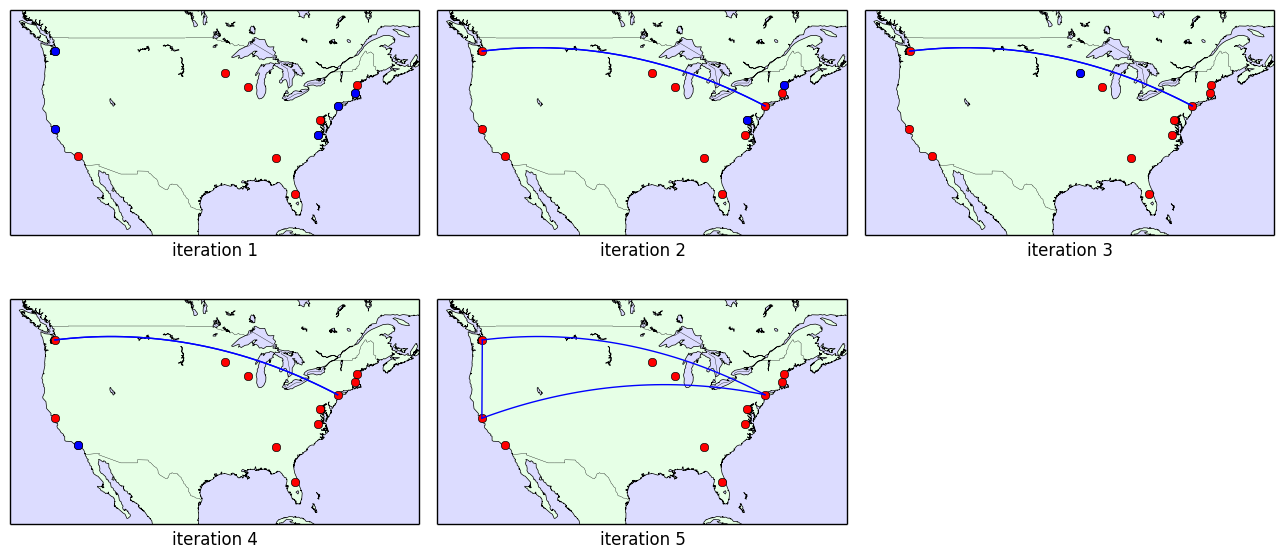

In [7]:
# plot the iterations as we eliminate subtours
figure(figsize=(13,6))
for i = 1:5
    subplot(2,3,i)
    mapSolution(sols[i])
    xlabel(string("iteration ",i))
end
tight_layout()
#savefig("tsp_sol_elim.pdf")

From the graph, we can learn that our result is quite reasonable.

## 5. Conclusion ##

Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.